
## Karate Club

Zachary's Karate Club graph

Data file from:
http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm

Zachary W. (1977).
An information flow model for conflict and fission in small groups.
Journal of Anthropological Research, 33, 452-473.

## sudoku_graph

## random_internet_as_graph


In [4]:
%matplotlib inline

import urllib.request
import io
import zipfile

from pathlib import Path
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

import igraph as ig

In [111]:
#instance

inst_="karate_club"
G = nx.karate_club_graph()

#inst_="sudoku"
#G = nx.sudoku_graph(5)

#inst_="random_tree"
#G = nx.random_tree(50)

#inst_="random_internet_100"
#G = nx.random_internet_as_graph(100)

# erdos_renyi_graph(n, p, seed=None, directed=False)
#G = nx.erdos_renyi_graph(50,0.1)

# barabasi_albert_graph(n, m, seed=None, initial_graph=None)
#G = nx.barabasi_albert_graph()


#print("Node Degree")
#for v in G:
#    print(f"{v:4} {G.degree(v):6}")
#print(G)

In [112]:
nx.is_connected(G)

True

In [137]:
#if (0,1) in G.edges:
#    print("yes")
#else:
#    print("no")

#for e in G.edges:
#    (u,w) = e
#    print(u, w, e)

In [102]:
#print(list(G.nodes))
#print(list(G.edges))
#list(G.adj[1])  # or list(G.neighbors(1))
#G.degree[1]  # the number of edges incident to 1
#G[1]  # same as G.adj[1]
#nx.maximal_independent_set(G) 

In [103]:
#N = nx.neighbors(G,1)
#for i in N:
#    print(i)

In [104]:
#path = nx.single_source_dijkstra_path(G, 0)
#path

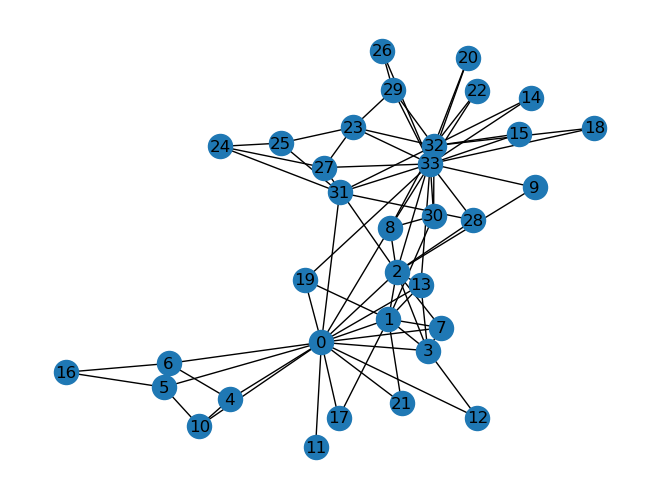

In [114]:
nx.draw(G, with_labels=True)
plt.show()

In [84]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

dm = np.zeros((N,N), dtype=int)

p = nx.shortest_path(G)

for i in range(0,N):
    for j in range(0,N):
        dm[i][j] = len(p[i][j])-1

#G.edges


In [86]:
# form0
form_="form0"
method_="lp"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status_ = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model(f"{method_}_{inst_}_{form_}")

    if (method_=="mip"):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
    
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MINIMIZE)
    
    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0
 
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1*x[i]
    model.addConstr(constr0 == 1)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 >= x[s])

    #x[i].Start = 1.0
    #relax = model.relax()    
    #relax.optimize()
    
    #model.write(f"{method_}_{inst_}_{form_}.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (method_=="mip"):
        lb[i] = model.objBound
        ub[i] = model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status_[i] = tmp
    else:
        ub[i] = model.objVal
        time[i] = model.Runtime
        status_[i] = tmp

    if (method_=="mip"):
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],3))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()

In [26]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1

In [88]:
# form1
form_="form1"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model(f"{method_}_{inst_}_{form_}")

    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0

    if (method_=="mip"):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
   
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MAXIMIZE)
     
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1 * x[i]
    model.addConstr(constr0 == 0)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 <= 1 + x[s])

    #x[i].Start = 0.0
    #relax = model.relax()
    #relax.optimize()

    #model.write(f"{method_}_{inst_}_{form_}.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (method_=="mip"):
        lb[i] = N - model.objBound
        ub[i] = N - model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status_[i] = tmp
    else:
        ub[i] = N - model.objVal
        time[i] = model.Runtime
        status_[i] = tmp

    if (method_=="mip"):
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()

In [28]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1

In [90]:
# cutForm1
form_="cutForm1"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model(f"{method_}_{inst_}_{form_}") #cria o modelo

    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0

    if (method_=="mip"):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
    
    obj = 0
    for j in G:
        obj += 1 * x[j]
         
    model.setObjective(obj, GRB.MAXIMIZE)
     
    # Turn off display and heuristics
    gp.setParam('OutputFlag', 0)
    gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1 * x[i]
    model.addConstr(constr0 == 0)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 <= 1 + x[s])

                            Is = nx.maximal_independent_set(G, [s])
                            for k in Is:
                                constr2 = 1 * x[k]
                            constr2 += 1 + (len(Is)- 1)*x[s]                            

    #relax = model.relax()
    #relax.optimize()

    #model.write(f"{method_}_{inst_}_{form_}.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    if (method_=="mip"):
        lb[i] = N - model.objBound
        ub[i] = N - model.objVal
        gap[i] = model.MIPGap
        time[i] = model.Runtime
        nodes[i] = model.NodeCount
        status_[i] = tmp
    else:
        ub[i] = N - model.objVal
        time[i] = model.Runtime
        status_[i] = tmp

    if (method_=="mip"):
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status_[i],1))+'\n')
        arquivo.close()

In [30]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1

In [136]:
# rltForm1
form_="rltForm1"
method_="mip"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    model = gp.Model(f"{method_}_{inst_}_{form_}")

    # configurando parametros
    # model.Params.TimeLimit = 60
    model.Params.MIPGap = 1.e-6
    model.Params.Threads = 1
    # model.Params.Presolve = 0
    # model.Params.Cuts = 0


    if (method_=="mip"):
        x = model.addVars(N, vtype=GRB.BINARY, name="x")
        #x = []
        #for u in range(0, N):
        #   x.append(m.addVar(vtype=GRB.BINARY,name="x_{}".format(u+1)))
    else:
        x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")

    #l = list(tuple())
    #for u in range(0, N):
    #    for w in range(u+1, N):
    #        l.append((u,w))

    #y = model.addVars(l, vtype=GRB.BINARY, name='y')

    obj = 0
    for u in range(N):
        obj += 1 * x[u]
        #for w in range(u+1,N):
        #    obj += y[u,w]
         
    model.setObjective(obj, GRB.MAXIMIZE)
     
    # Turn off display and heuristics
    #gp.setParam('OutputFlag', 0)
    #gp.setParam('Heuristics', 0)

    constr0 = 0
    constr0 += 1 * x[i]
    model.addConstr(constr0 == 0)

    for u in range(0,N):
        for w in range(u+1,N):
            if dm[u,w] <= N:
                for s in range(0,N):
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            constr1 = x[u] + x[w]
                            model.addConstr(constr1 <= 1 + x[s])

#    for u in range(0,N):
#        for w in range(u+1,N):
#            if (u,w) in G.edges: 
#                constrRlt1 = 1
#                model.addConstr(constrRlt1 <= x[u])

    for e in G.edges:
        (u,w) = e
        model.addConstr(1 <= x[u])

#    for u in range(0,N):
#        for w in range(u+1,N):
#            if (u,w) in G.edges: 
#                constrRlt2 = 1
#                model.addConstr(constrRlt2 <= x[w])

    for e in G.edges:
        (u,w) = e
        model.addConstr(1 <= x[u])

#    for u in range(0,N):
#        for w in range(u+1,N):
#            if (u,w) in G.edges: 
#                constrRlt3 = x[u] + x[w]
#                model.addConstr(constrRlt3 <= 1 + 1)

    for e in G.edges:
        (u,w) = e
        model.addConstr(x[u] + x[w] <= 1 + 1)

    #x[i].Start = 0.0
    #relax = model.relax()
    #relax.optimize()

    model.write(f"{method_}_{inst_}_{form_}.lp")

    model.optimize()

    tmp = 0
    if model.status == GRB.OPTIMAL:
        tmp = 1
    
    #if (method_=="mip"):
    #    lb[i] = N - model.objBound
    #    ub[i] = N - model.objVal
    #    gap[i] = model.MIPGap
    #    time[i] = model.Runtime
    #    nodes[i] = model.NodeCount
    #    status_[i] = tmp
    #else:
    #    ub[i] = N - model.objVal
    #    time[i] = model.Runtime
    #    status_[i] = tmp

    #if (method_=="mip"):
    #    arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
    #    tmp = i
    #    arquivo.write(
    #        str(tmp)+';'
    #        +str(round(lb[i],1))+';'
    #        +str(round(ub[i],1))+';'
    #        +str(round(gap[i],2))+';'
    #        +str(round(time[i],2))+';'
    #        +str(round(nodes[i],1))+';'
    #        +str(round(status_[i],1))+'\n')
    #    arquivo.close()
    #else:
    #    arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
    #    tmp = i
    #    arquivo.write(
    #        str(tmp)+';'
    #        +str(round(ub[i],1))+';'
    #        +str(round(time[i],2))+';'
    #        +str(round(status_[i],1))+'\n')
    #    arquivo.close()

In [ ]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1